![Assimila logo](../helpers/logosmall.png "Assimila")
# Assimila Prise Products
# Analyse Temperature and Anomalies

If the drop down menus do not appear restart the notebook by selecting "Kernel" then "Restart" above.

In [4]:
import os
import sys
sys.path.append('../helpers')

#from widgets import Widgets

import matplotlib

import matplotlib.cm as cm
import matplotlib.animation as animation

import matplotlib.cbook as cbook
import matplotlib.image as image

matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import gdal
import numpy as np
import xarray as xr

import ipywidgets as widgets
import pandas as pd
import datetime

from IPython.display import clear_output
from IPython.display import display

from IPython.core.display import display, HTML


/home/rcarmichael/.conda/envs/req1.1/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [56]:
def get_chunk_size(filename):
    """
    Extract the block size and raster count so that the
    chunks tuple can be formed, a parameter needed to read
    a dataset using xr.open_rasterio() using DASK.
    :param filename: GDAL valid file.
    :return: tuple raster count, x block size, y block size
    """

    # Extract raster count and block size from file
    d = gdal.Open(filename)
    raster_count = d.RasterCount
    # Get internal block size from first band
    b = d.GetRasterBand(1)
    block_size = b.GetBlockSize()
    chunks = (raster_count, block_size[0], block_size[1])

    return chunks

def get_times_from_file_band(fname):
    """
    Extract time info from band metadata
    """
    d = gdal.Open(fname)

    # Get dataset metadata
    dmd = d.GetMetadata()
    bands = d.RasterCount

    # Empty times list
    times = []

    for band in range(bands):
        b = d.GetRasterBand(band+1)
        # Get band metadata
        md = b.GetMetadata()
        print(md)
        # Get fields with date info
        key = 'last_gold'
        if key in md:
            start_date = md[key]
        elif key in dmd:
            start_date = dmd[key]
        else:
            err_msg = f"File {fname} does not have date information"
            raise Exception(err_msg)

        times.append(np.datetime64(start_date))

    return times

def get_data(month):
    # Get monthly ERA5 data
    #datadir = '/home/glopez/Projects/ClimateRiskDisclosure/ERA5/Europe'
    datadir = '../ERA5/Africa'

    fname = os.path.join(datadir, f'era5_t2m_era5_africa_2009-{month}.tif')
    
    times = get_times_from_file_band(fname)

    chunks = get_chunk_size(fname)
    data_array = xr.open_rasterio(fname)

    data_array = data_array.rename(
        {'x': 'longitude',
         'y': 'latitude',
         'band': 'time'})

    data_array['time'] = times
    
    # Get stats 
    stats = xr.zeros_like(data_array)
    _mean = data_array.mean(axis=0)
    _std = data_array.std(axis=0)
    
    # Get standard anomalies
    for i, layer in enumerate(data_array):
        stats.data[i] = (data_array.data[i] - _mean.data) / _std.data
    
    return data_array, stats, times

In [57]:
times = None

# Get data
datasets = [] # entry for each month read in 
anomalies = []
months = ['01', '02', '03', '04', '05', '06',
          '07', '08', '09', '10', '11', '12']

for month in months:
    # Get anomalies and datasets
    d, a, t = get_data(month)
    datasets.append(d)
    anomalies.append(a)
print(len(t))
# TODO:
# combine all entries in dataset and anomalies 
# product dataset2 and anomalies2 with
# entry for max, mean and min
# these are then plotted below

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{

744


In [55]:
x = datasets[0]
y = datasets[1]
z = xr.merge([x.to_dataset(name='a'), y.to_dataset(name='a')])

print(z)

ValueError: cannot reindex or align along dimension 'time' because the index has duplicate values

In [ ]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def on_dropdown_dates_change(change):
    """
    Handles change event on dropdown_farms widget
    """
    if change['type'] == 'change' and change['name'] == 'value':
        for i, variable in enumerate(variables):
            #ts_plots[i].clear()
            plots[i].clear()
            
            index = np.where(t==dropdown_dates.value)[0][0]
            
            images[i] = anomalies[i][index].plot.imshow(ax=plots[i], cmap=colormaps[i],
                                                  vmin=vmin_vmax[i][0], vmax=vmin_vmax[i][1],
                                                  add_colorbar=False)
    
            plots[i].set_title(f'{variable} anomalies')
            plots[i].set_aspect('equal')
            #colorbars.append(fig.colorbar(tmp_img, ax=plots[i], orientation="horizontal"))
            plots[i].grid()
        
        fig.canvas.draw()
        plt.show()
        
def on_click(event):
    """
    Event handler
    """
    # Event does not apply for time series plot
    # Check if the click was in a
    if event.inaxes in ts_plots:
        return
    
    for i, ax in enumerate(plots):
       
        ts_plots[i].clear()
    
        # Delete last reference point
        if len(ax.lines) > 0:
            del ax.lines[0]

        # Draw a point as a reference
        ax.plot(event.xdata, event.ydata,
                marker='o', color='red', markersize=7, alpha=0.7)
    
        _data = datasets[i].sel(longitude=event.xdata,
                                latitude=event.ydata,
                                method='nearest')
            
        ts_plots[i].plot(_data.time.data, _data.data, label=f'ERA5 {variables[i]}',
                         color=colors[i], lw=1.5, alpha=0.5)
        
        # Mean
        #ts_plots[i].hlines(_data.mean().data, _data.time.data[0], _data.time.data[-1],
        #                   colors=colors[i], linestyles='-', lw=1.0, alpha=0.3)
    
        # 90% and 10% percentile
        _quantile = _data.quantile([0.1,0.9]).data
        ts_plots[i].hlines(_quantile, _data.time.data[0], _data.time.data[-1],
                        colors=colors[i], linestyles='--', lw=1.0, alpha=0.3)
    
        #bx.legend(loc='best', fontsize='small',
        #              fancybox=True, framealpha=0.5)
        
        ts_plots[i].fill_between(_data.time.data, _quantile[1], _data,
                    where=_data >= _quantile[1],
                    facecolor=colors[i], interpolate=True, alpha=0.5)
    
        ts_plots[i].fill_between(_data.time.data, _quantile[0], _data,
                    where=_data <= _quantile[0],
                    facecolor=colors[i], interpolate=True, alpha=0.5)
        
        #bx.fill_between(data_array.time.data, _quantile[0], _data,
        #                where=_data <= _quantile[0],
        #                facecolor='blue', interpolate=True, alpha=0.5)

        #title = bx.get_title()
        ts_plots[i].set_title('')
        
        ts_plots[i].yaxis.label.set_color(colors[i])
        tkw = dict(size=4, width=1.5)
        ts_plots[i].tick_params(axis='y', colors=colors[i], **tkw)
        ts_plots[i].set_ylabel(variables[i])

        
    #ts_plots[0].legend(loc='best', fontsize='small',
    #          fancybox=True, framealpha=0.5)
    
    ts_plots[0].grid()
    ts_plots[-1].spines["right"].set_position(("axes", 1.07))
    make_patch_spines_invisible(ts_plots[-1])
    ts_plots[-1].spines["right"].set_visible(True)
    fig.canvas.draw()
    

In [23]:
# Widgets
w = Widgets()

freq = ['days', 'months', 'years']

lat = w.latitude()
lon = w.longitude()
start = w.get_date(value=datetime.date(2009,1,1), description='Start')
end = w.get_date(value=datetime.date(2009,12,31), description='End')
dropdown_dates = widgets.Dropdown(description='Date selection',
                        disabled=False)
timestep = widgets.Dropdown(options=freq,
                            description='Timestep',
                            disabled=False)

dropdown_dates.observe(on_dropdown_dates_change)

box1 = widgets.HBox([lat, lon])
box2 = widgets.HBox([start, end, timestep, dropdown_dates])
box = widgets.VBox([box1, box2])


<IPython.core.display.Javascript object>


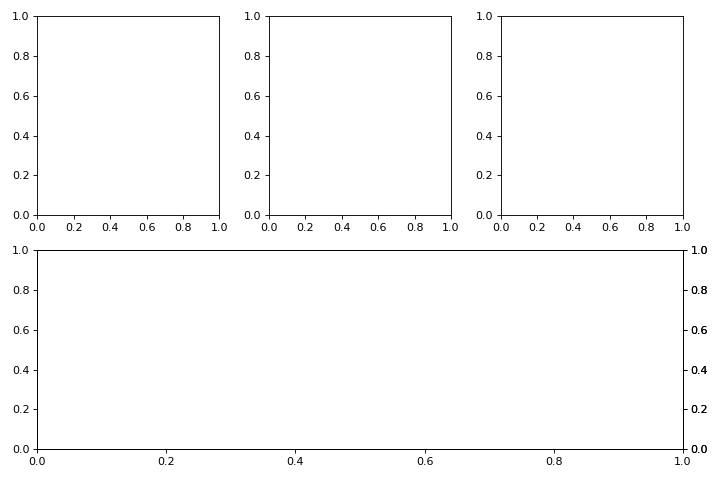

In [24]:
# Plot objects

fig = plt.figure(figsize=(9, 6))

t2m_min = plt.subplot2grid((2, 3), (0, 0), colspan=1)       

t2m_mean = plt.subplot2grid((2, 3), (0, 1), colspan=1,
                                         sharex=t2m_min, sharey=t2m_min)

t2m_max = plt.subplot2grid((2, 3), (0, 2), colspan=1,
                                sharex=t2m_min, sharey=t2m_min)

plots = [t2m_min, t2m_mean, t2m_max]
variables = ['t2m_min', 't2m_mean', 't2m_max']

ts_p = plt.subplot2grid((2, 3), (1, 0), colspan=3)
ts_p1 = ts_p.twinx()
ts_p2 = ts_p.twinx()

ts_plots = [ts_p, ts_p1, ts_p2]

plt.tight_layout()
display(box)
plt.show()